# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
#Reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
#Load data
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print("\nColumn types:")
display(df.dtypes.value_counts())


Column types:


,count
object,18
int64,2
float64,1


In [6]:
print("\nChurn distribution (counts):")
display(df['Churn'].value_counts())


Churn distribution (counts):


,count
Churn,
No,5174
Yes,1869


In [7]:
print("\nChurn distribution (proportions):")
display(df['Churn'].value_counts(normalize=True))


Churn distribution (proportions):


,proportion
Churn,
No,0.73463
Yes,0.26537


In [8]:
#Data cleaning
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Inspect rows with missing TotalCharges
missing_tc = df[df['TotalCharges'].isna()]
print("Rows with missing TotalCharges:", missing_tc.shape[0])
if not missing_tc.empty:
    display(missing_tc.head())

#Drop rows with missing TotalCharges
df = df[df['TotalCharges'].notna()].copy()
df.reset_index(drop=True, inplace=True)

Rows with missing TotalCharges: 11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No


In [9]:
# Drop identifier
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Map target to numeric
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

print("After cleaning shape:", df.shape)


After cleaning shape: (7032, 20)


/tmp/ipython-input-3787337931.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


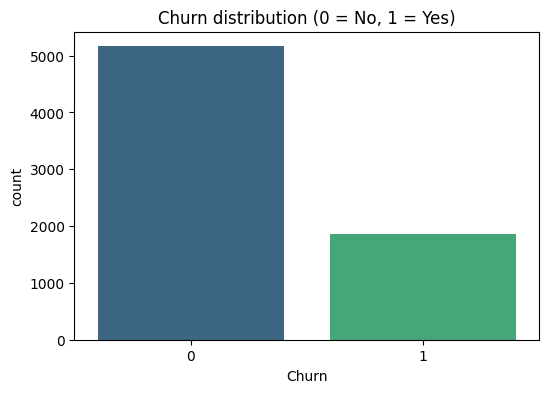

In [10]:
#Visualizations
#Churn countplot
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Churn distribution (0 = No, 1 = Yes)')
plt.show()

/tmp/ipython-input-2458575327.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=ax, palette='coolwarm')
/tmp/ipython-input-2458575327.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=ax, palette='coolwarm')
/tmp/ipython-input-2458575327.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=ax, palette='coolwarm')


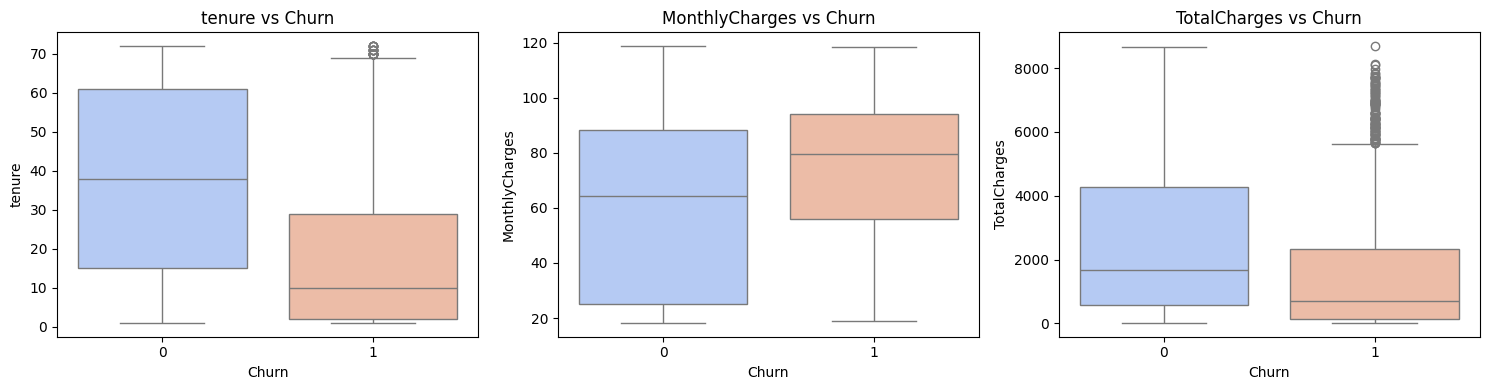

In [11]:
#Boxplots for numeric features vs churn
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, len(num_cols), figsize=(5*len(num_cols), 4))
for ax, col in zip(axes, num_cols):
    sns.boxplot(x='Churn', y=col, data=df, ax=ax, palette='coolwarm')
    ax.set_title(f'{col} vs Churn')
plt.tight_layout()
plt.show()

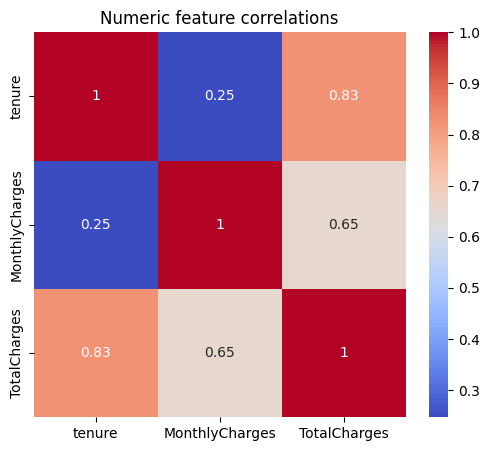

In [12]:
#Correlation heatmap for numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Numeric feature correlations')
plt.show()